In [1]:
%matplotlib inline

# useful packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
import time
import pandas as pd

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit.quantum_info import Statevector
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere
import qiskit

In [2]:
# graph generation

def draw_graph(G, colors, pos):
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
        edge_labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def graph_generation(dim):
    # Generating the system
    N = dim
    G1 = nx.grid_2d_graph(N,N)
    pos = dict( (n, n) for n in G1.nodes() )
    labels = dict( ((i, j), i * N + j) for i, j in G1.nodes() )
    # Transform to weighted graph:
    n = N**2
    V = np.arange(0, N, 1)

    E =[]

    tuples = []
    other_tup = []
    point_edge_map = []
    other_map = []
    relations = []

    for edge in G1.edges:
        point1 = edge[0]
        strpoint1 = str(point1[0]) + str(point1[1])
        point2 = edge[1]
        strpoint2 = str(point2[0]) + str(point2[1])
        if not strpoint1 in point_edge_map:
            point_edge_map.append(strpoint1)
            tuples.append(edge[0])
        if not strpoint2 in other_map:
            other_map.append(strpoint2)
            other_tup.append(edge[1])
        relations.append((strpoint1, strpoint2))

    tuples.append(other_tup[len(other_tup) - 1])
    point_edge_map.append(other_map[len(other_map) - 1])

    dic = {}
    for i in range(len(point_edge_map)):
        dic[i] = point_edge_map[i]

    point_edge_map = np.array(point_edge_map)
    relations = np.array(relations)

    for relation in relations:
        ver1 = relation[0]
        ver2 = relation[1]
        point1 = np.where(point_edge_map == ver1)[0][0]
        point2 = np.where(point_edge_map == ver2)[0][0]
        edge = (point1, point2, 1.0)
        E.append(edge)

    G = nx.Graph()

    G.add_nodes_from(V)

    G.add_weighted_edges_from(E)

    colors = ["b" for node in G.nodes()]
    pos = dict()
    for i in range(n):
        pos[i] = tuples[i]


    # draw_graph(G, colors, pos)
    
    # Matrix Representation of Graph
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = temp["weight"]
                
    return G, w, pos

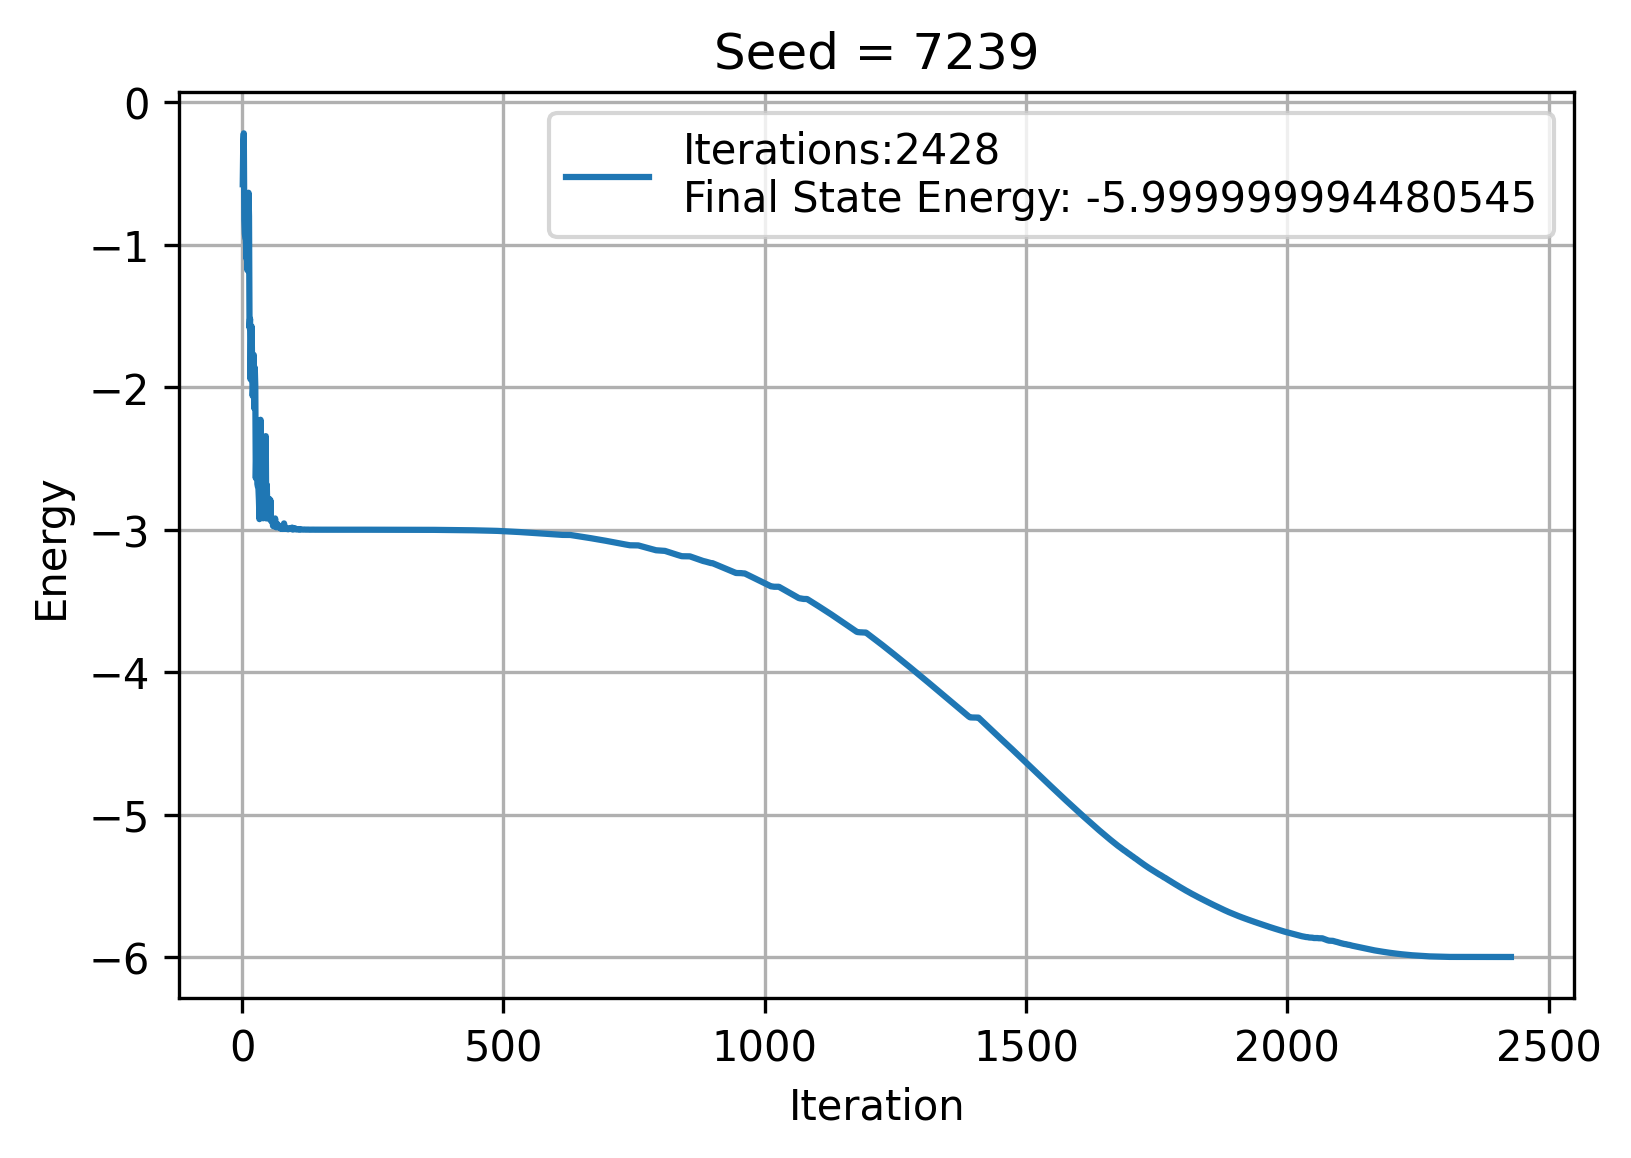

In [39]:
seed = 7239
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(3)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
# construct VQE
cobyla = COBYLA(maxiter=20000)
ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
counts, values = [], []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
vqe = VQE(ry, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=quantum_instance)
    
# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
plt.figure(dpi = 300)
plt.plot(converge_cnts, converge_vals, label =  "Iterations:" + str(int(len(converge_cnts))) + "\n" + "Final State Energy: " + str(converge_vals[-1]))
plt.title('Seed = ' + str(seed))
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.grid()
plt.show()

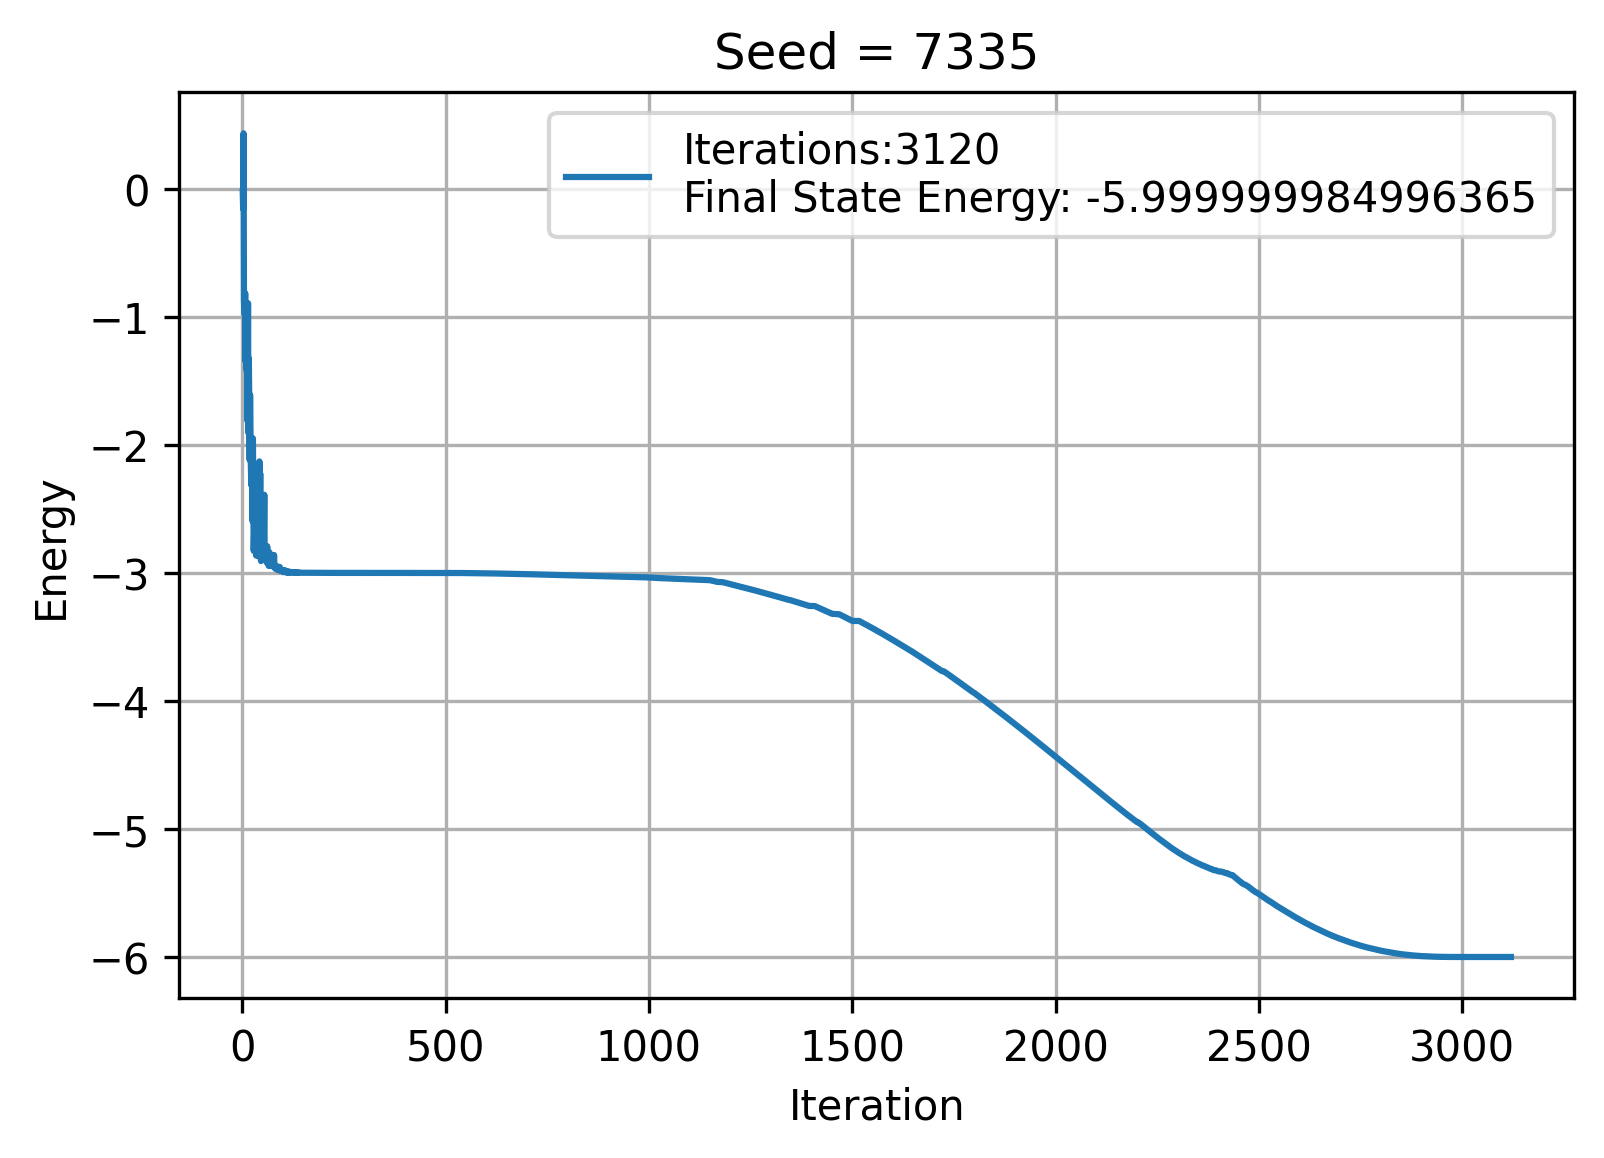

In [37]:
seed = 7335
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(3)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
# construct VQE
cobyla = COBYLA(maxiter=20000)
ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
counts, values = [], []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
vqe = VQE(ry, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=quantum_instance)
    
# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
plt.figure(dpi = 300)
plt.plot(converge_cnts, converge_vals, label =  "Iterations:" + str(int(len(converge_cnts))) + "\n" + "Final State Energy: " + str(converge_vals[-1]))
plt.title('Seed = ' + str(seed))
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.grid()
plt.show()

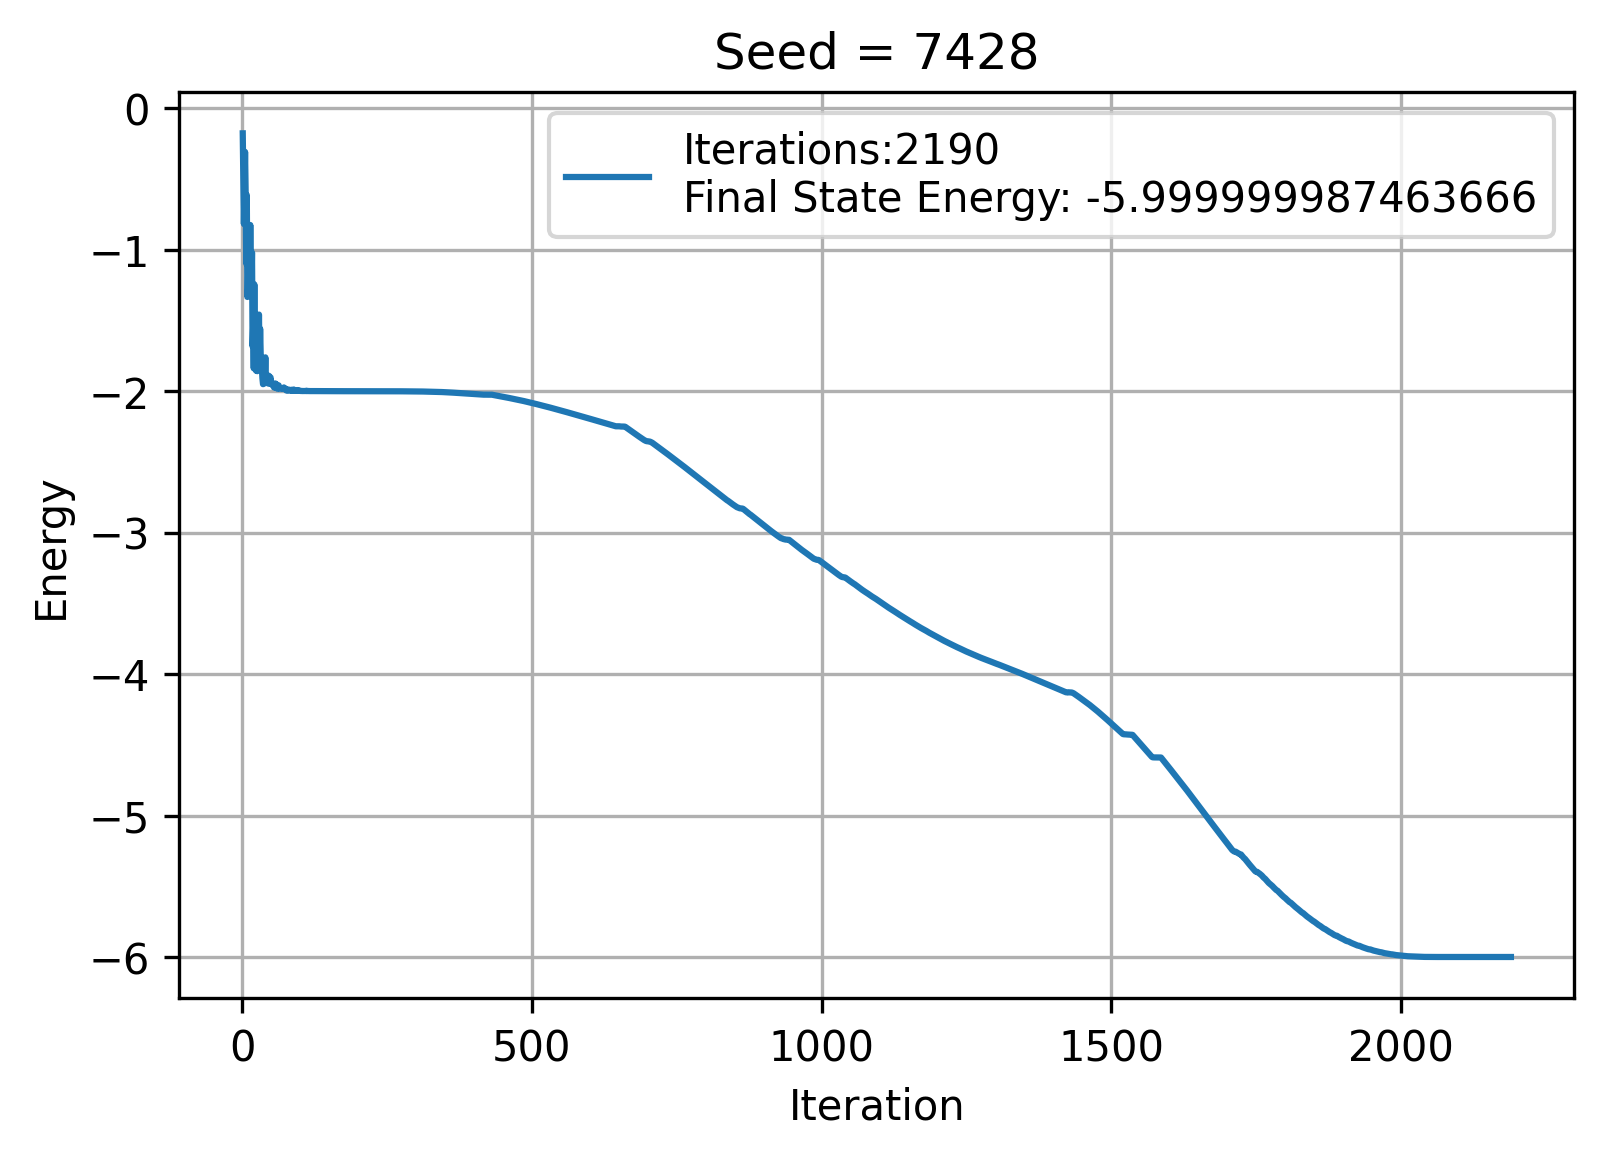

In [40]:
seed = 7428
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(3)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
# construct VQE
cobyla = COBYLA(maxiter=20000)
ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
counts, values = [], []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
vqe = VQE(ry, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=quantum_instance)
    
# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
plt.figure(dpi = 300)
plt.plot(converge_cnts, converge_vals, label =  "Iterations:" + str(int(len(converge_cnts))) + "\n" + "Final State Energy: " + str(converge_vals[-1]))
plt.title('Seed = ' + str(seed))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.grid()
plt.show()

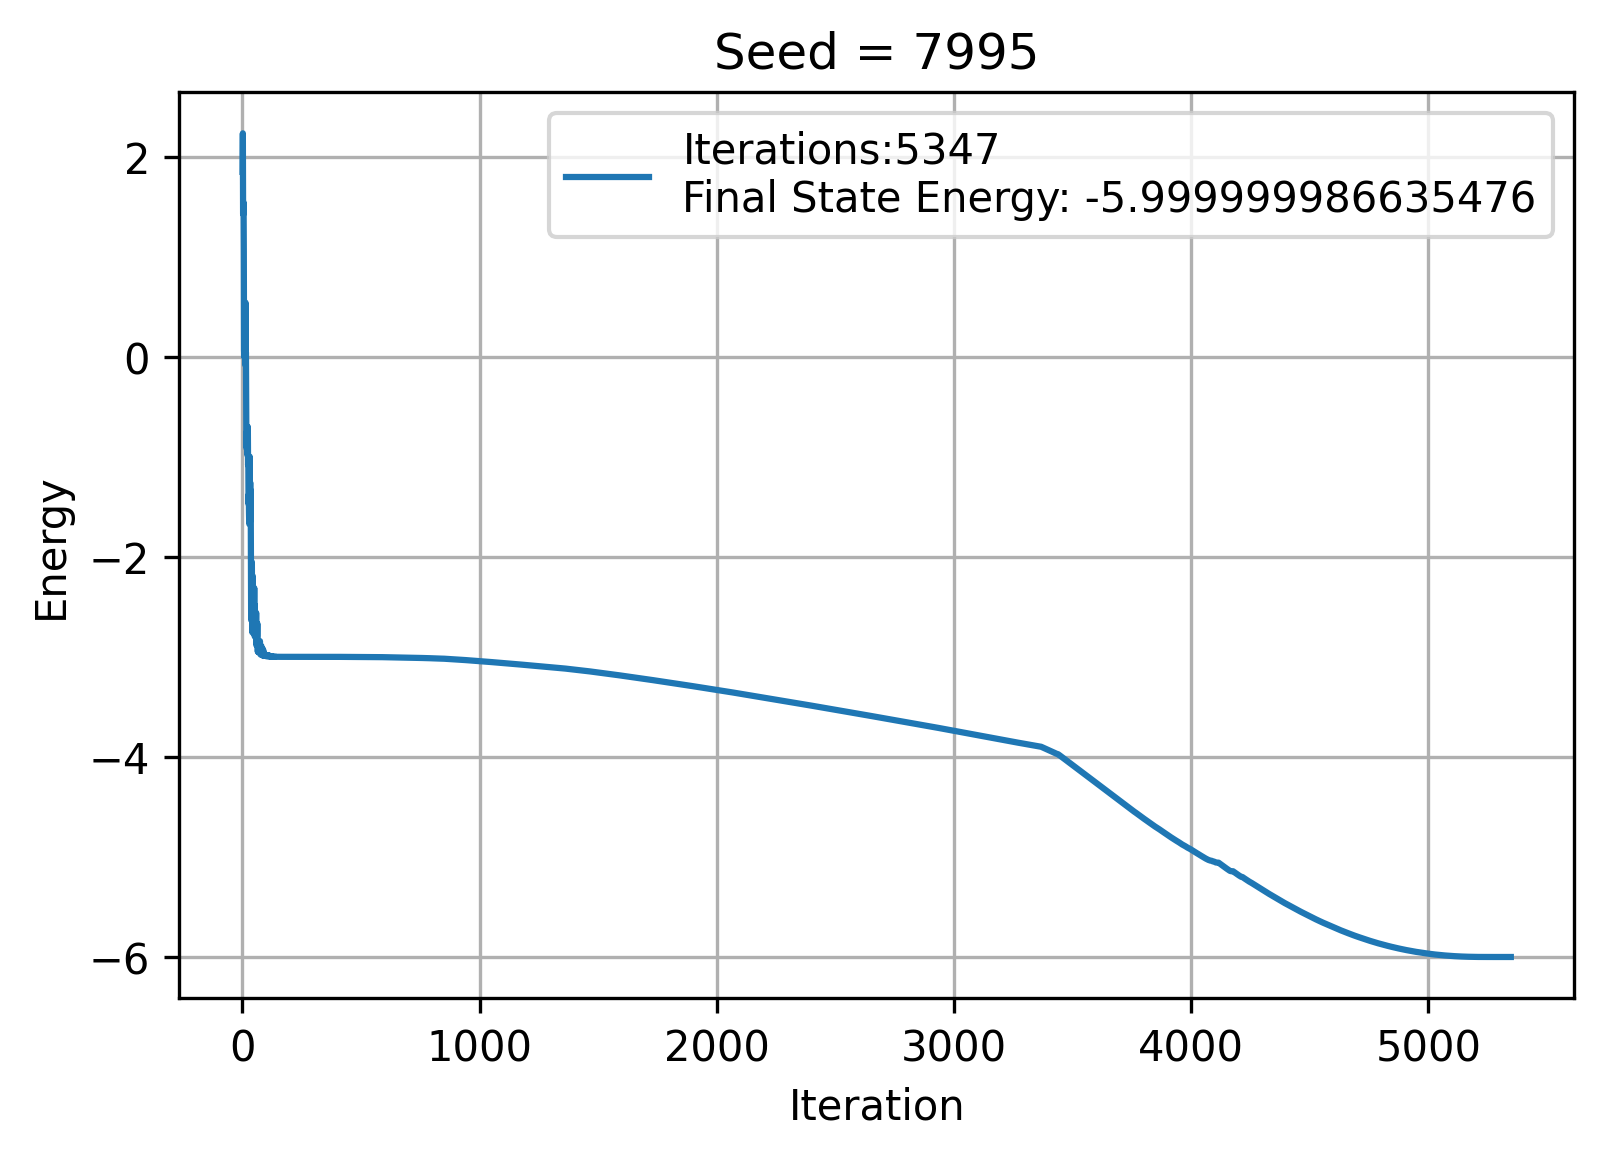

In [38]:
seed = 7995
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(3)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
# construct VQE
cobyla = COBYLA(maxiter=20000)
ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
counts, values = [], []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
vqe = VQE(ry, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=quantum_instance)
    
# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
plt.figure(dpi = 300)
plt.plot(converge_cnts, converge_vals, label =  "Iterations:" + str(int(len(converge_cnts))) + "\n" + "Final State Energy: " + str(converge_vals[-1]))
plt.title('Seed = ' + str(seed))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.grid()
plt.show()

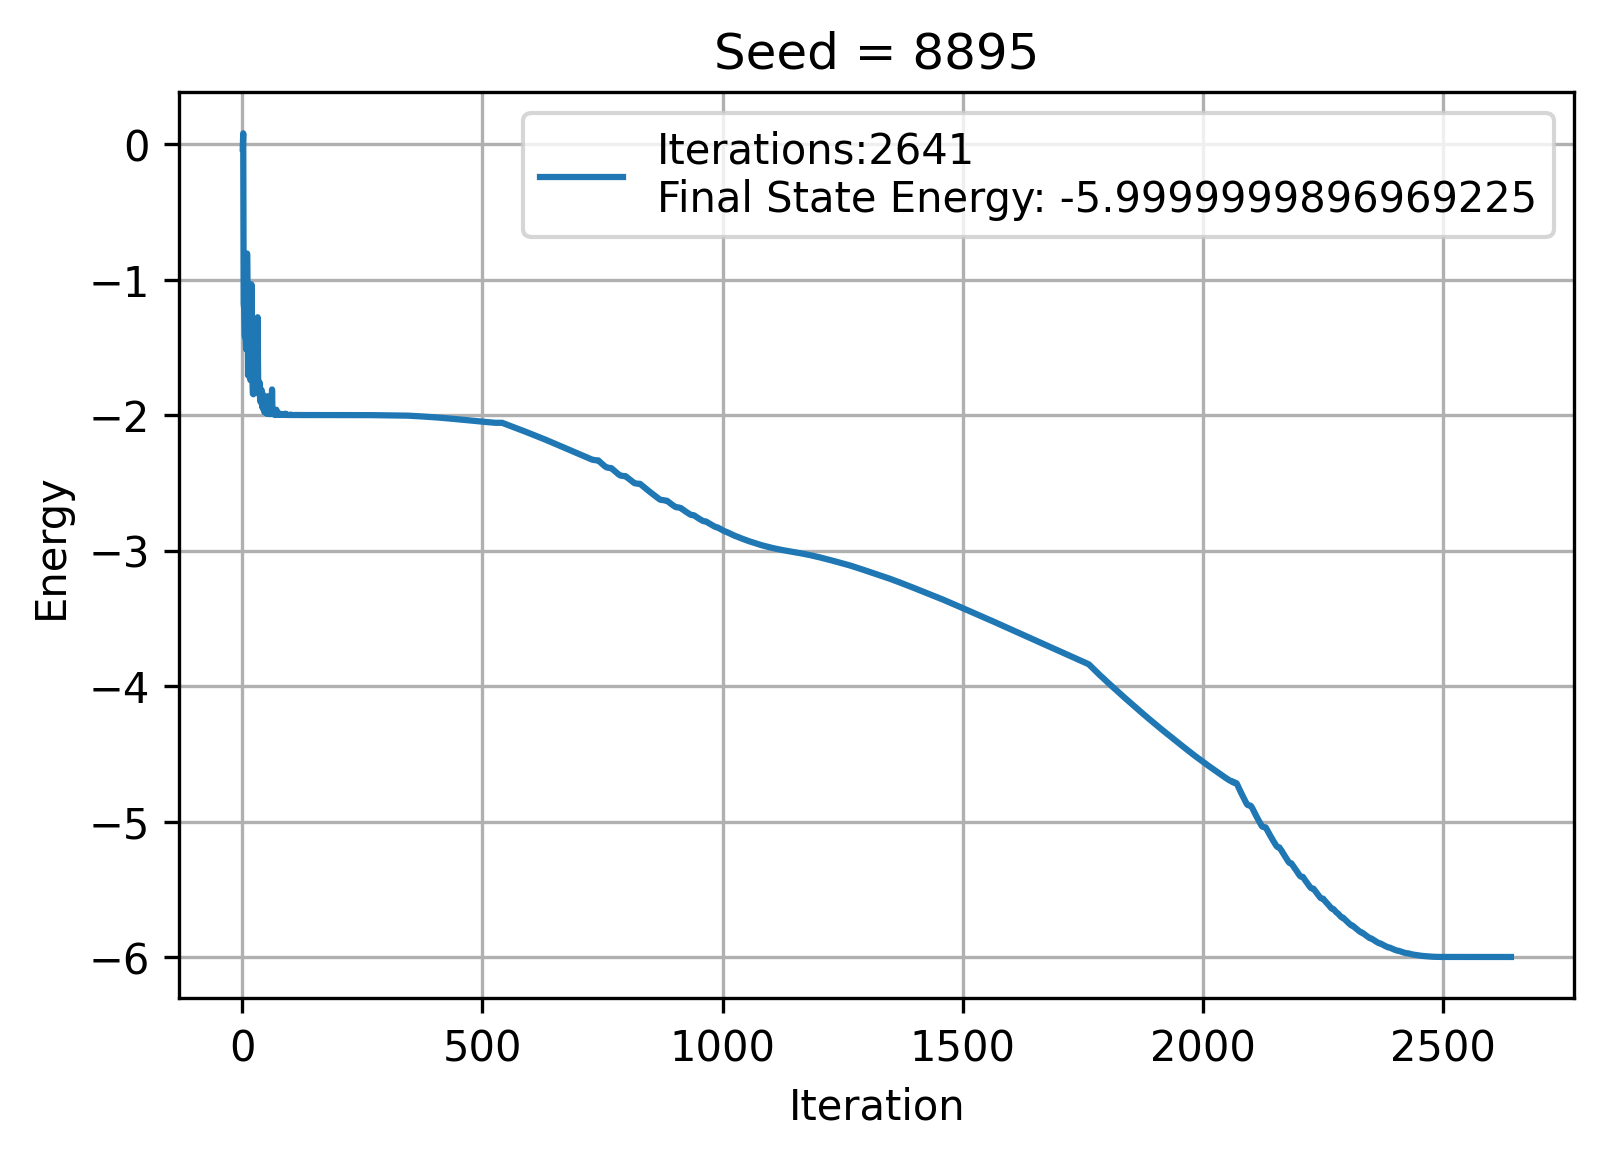

In [41]:
seed = 8895
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(3)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
# construct VQE
cobyla = COBYLA(maxiter=20000)
ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
counts, values = [], []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
vqe = VQE(ry, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=quantum_instance)
    
# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
plt.figure(dpi = 300)
plt.plot(converge_cnts, converge_vals, label =  "Iterations:" + str(int(len(converge_cnts))) + "\n" + "Final State Energy: " + str(converge_vals[-1]))
plt.title('Seed = ' + str(seed))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.grid()
plt.show()

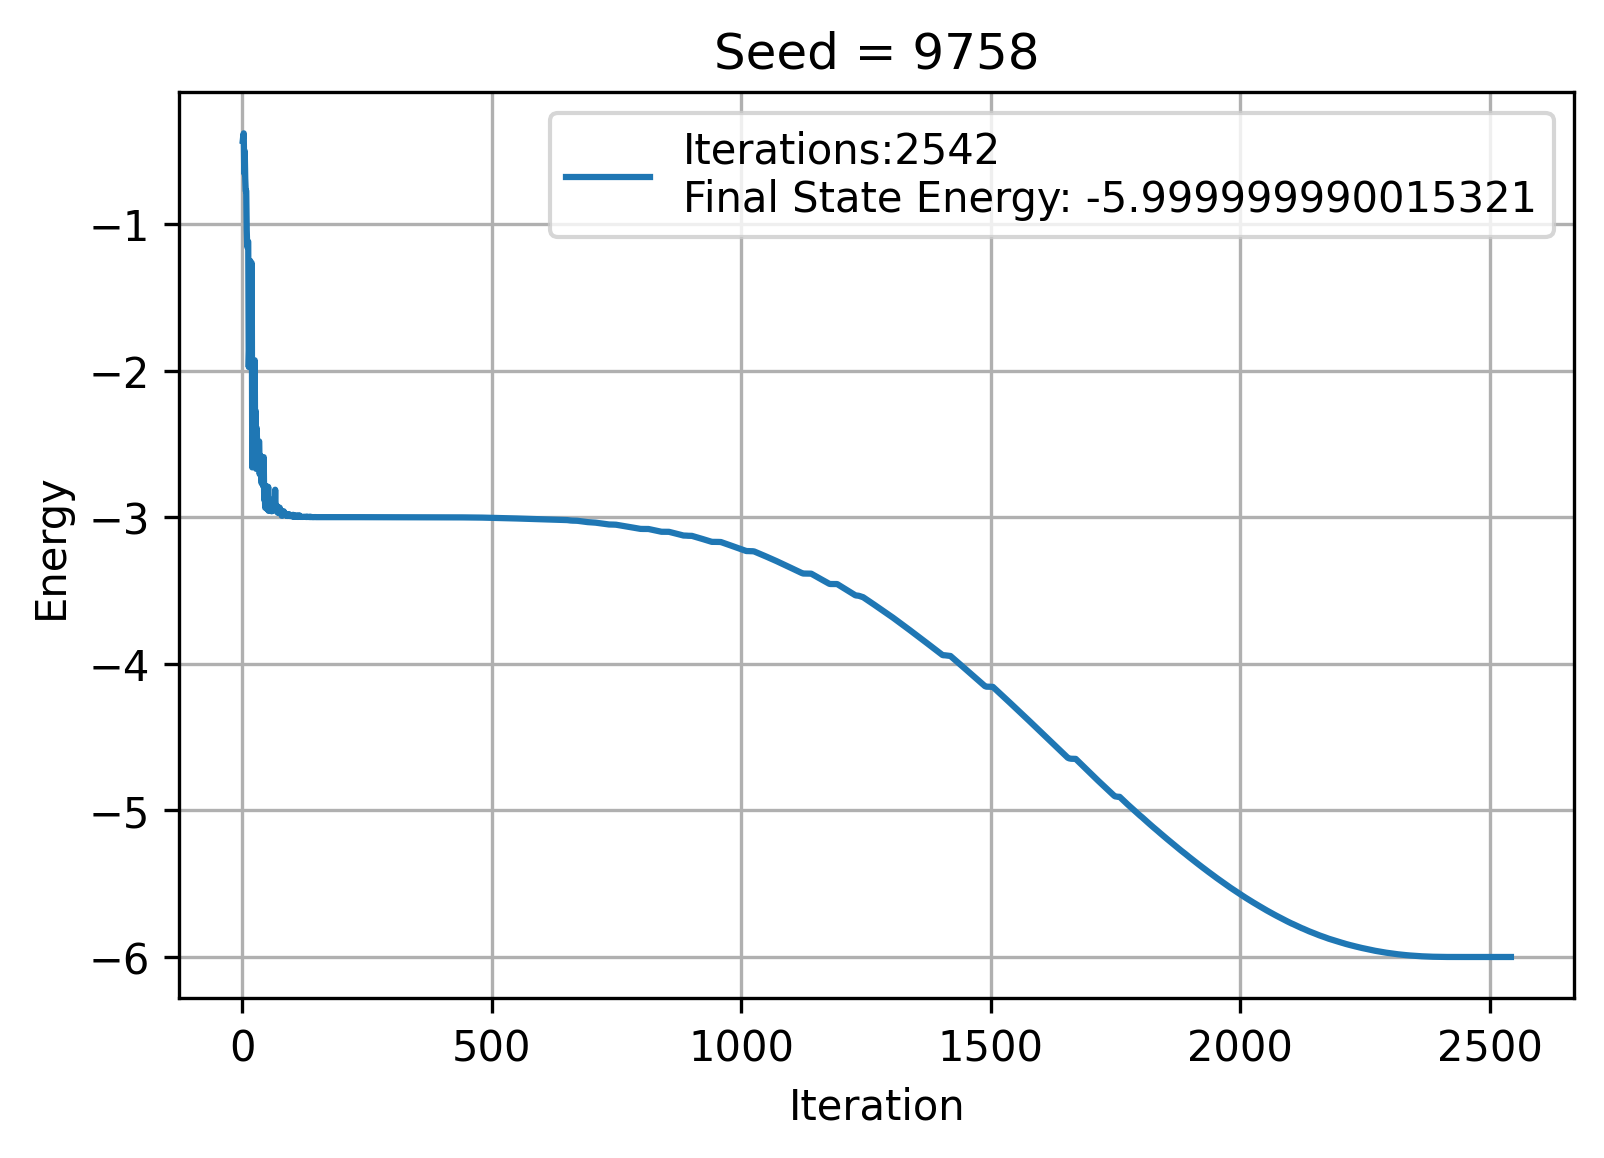

In [42]:
seed = 9758
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(3)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
# construct VQE
cobyla = COBYLA(maxiter=20000)
ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
counts, values = [], []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
vqe = VQE(ry, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=quantum_instance)
    
# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
plt.figure(dpi = 300)
plt.plot(converge_cnts, converge_vals, label =  "Iterations:" + str(int(len(converge_cnts))) + "\n" + "Final State Energy: " + str(converge_vals[-1]))
plt.title('Seed = ' + str(seed))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.grid()
plt.show()

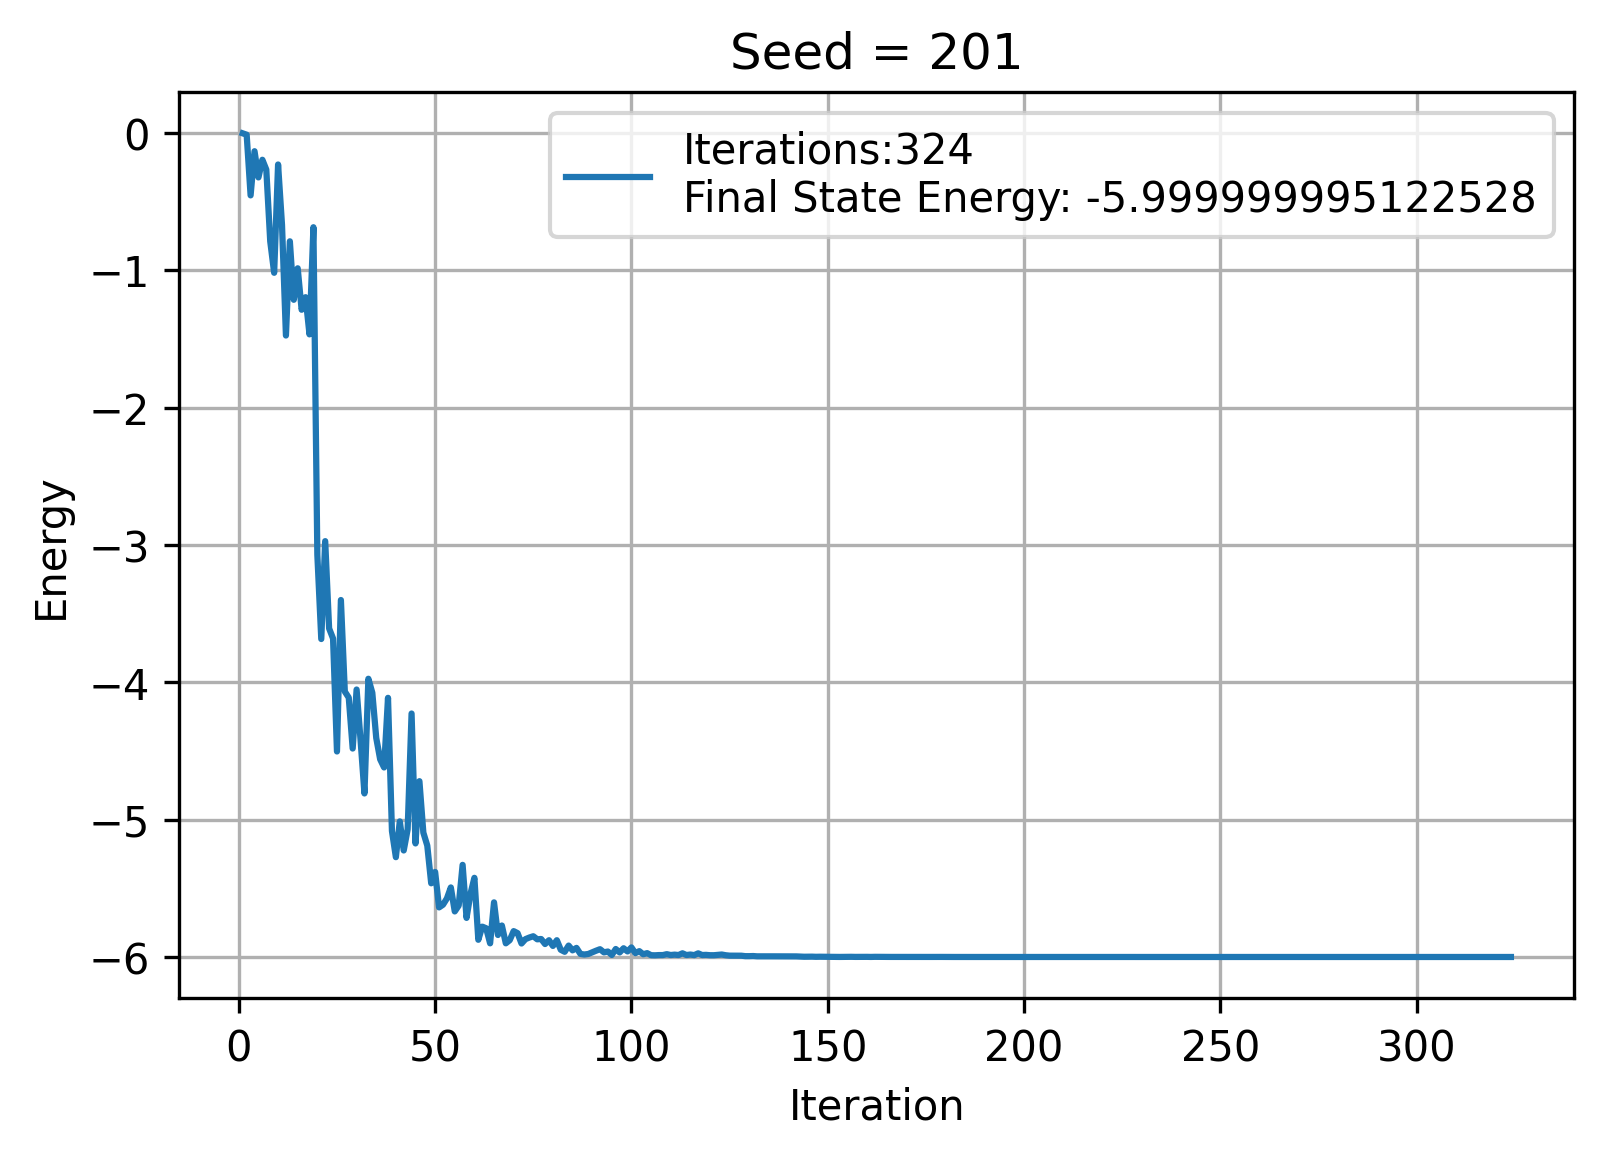

In [23]:
seed = 201
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(3)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
# construct VQE
cobyla = COBYLA(maxiter=2000)
ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
counts, values, Parameters = [], [], []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    Parameters.append(parameters)
vqe = VQE(ry, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=quantum_instance)
    
# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
plt.figure(dpi = 300)
plt.plot(converge_cnts, converge_vals, label =  "Iterations:" + str(int(len(converge_cnts))) + "\n" + "Final State Energy: " + str(converge_vals[-1]))
plt.title('Seed = ' + str(seed))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.grid()
plt.show()

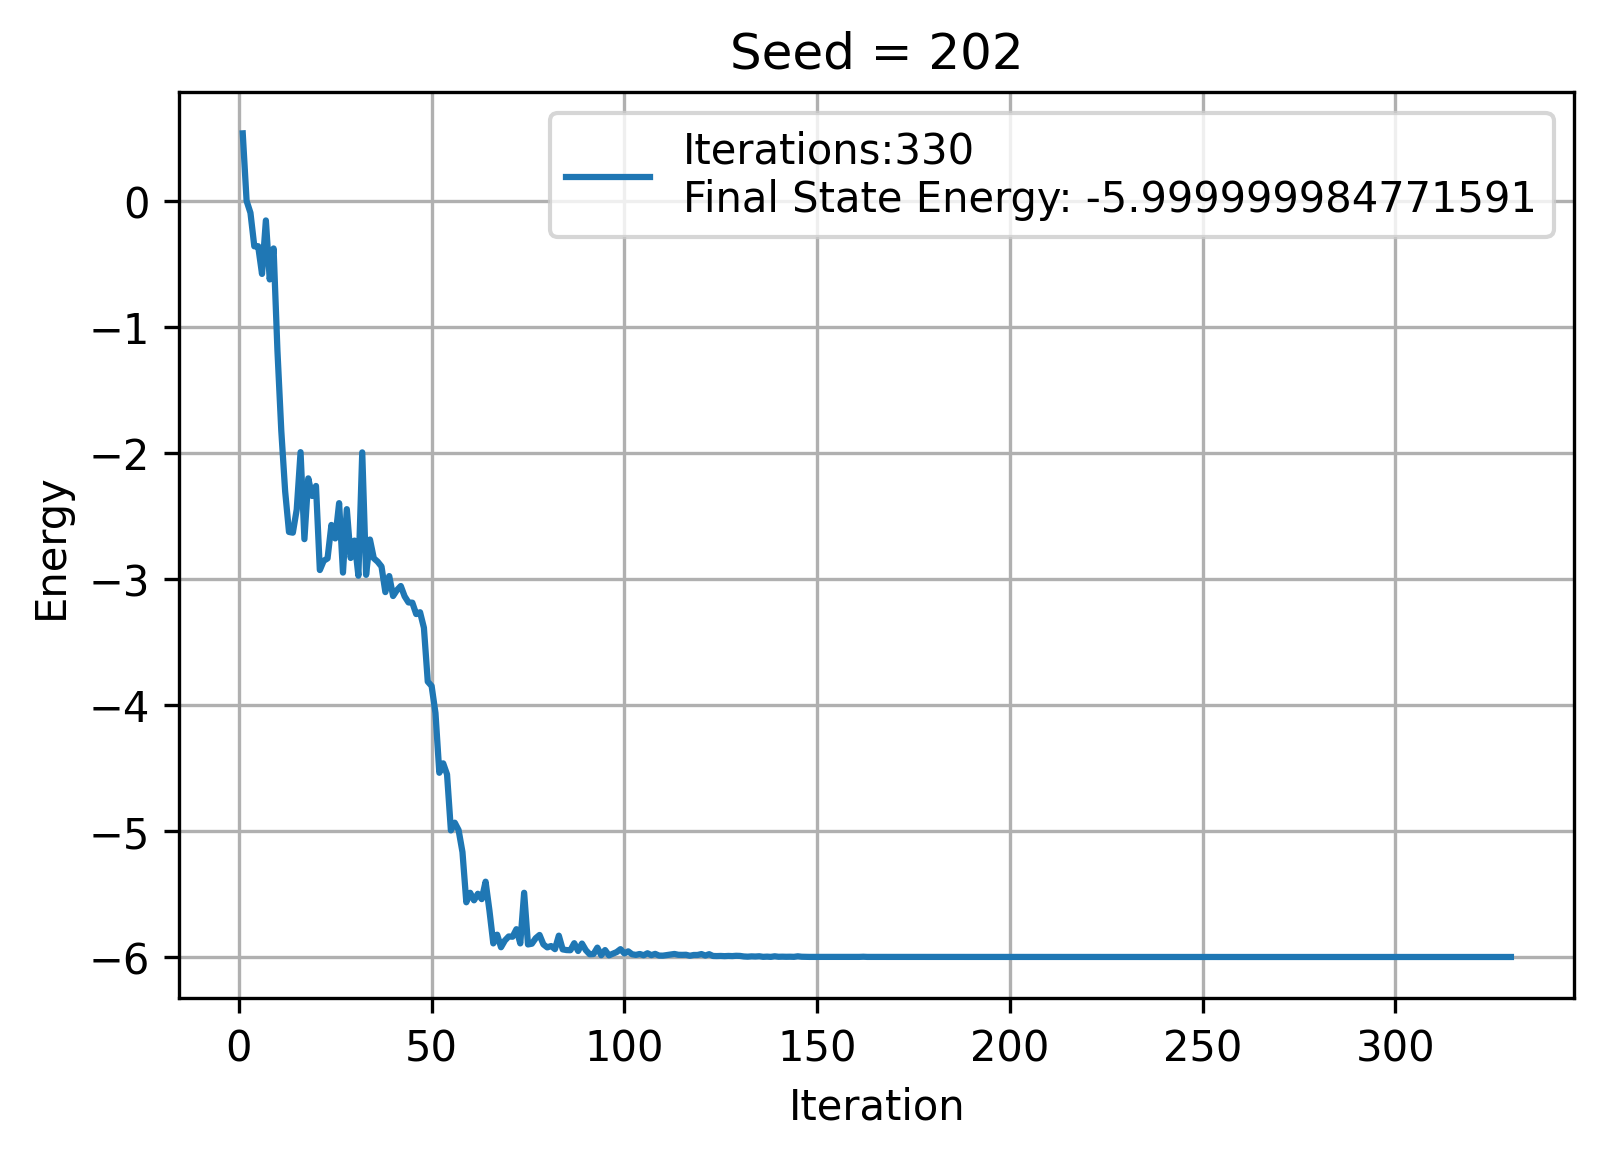

In [27]:
seed = 202
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(3)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
# construct VQE
cobyla = COBYLA(maxiter=2000)
ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
counts, values = [], []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
vqe = VQE(ry, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=quantum_instance)
    
# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
plt.figure(dpi = 300)
plt.plot(converge_cnts, converge_vals, label =  "Iterations:" + str(int(len(converge_cnts))) + "\n" + "Final State Energy: " + str(converge_vals[-1]))
plt.title('Seed = ' + str(seed))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.grid()
plt.show()

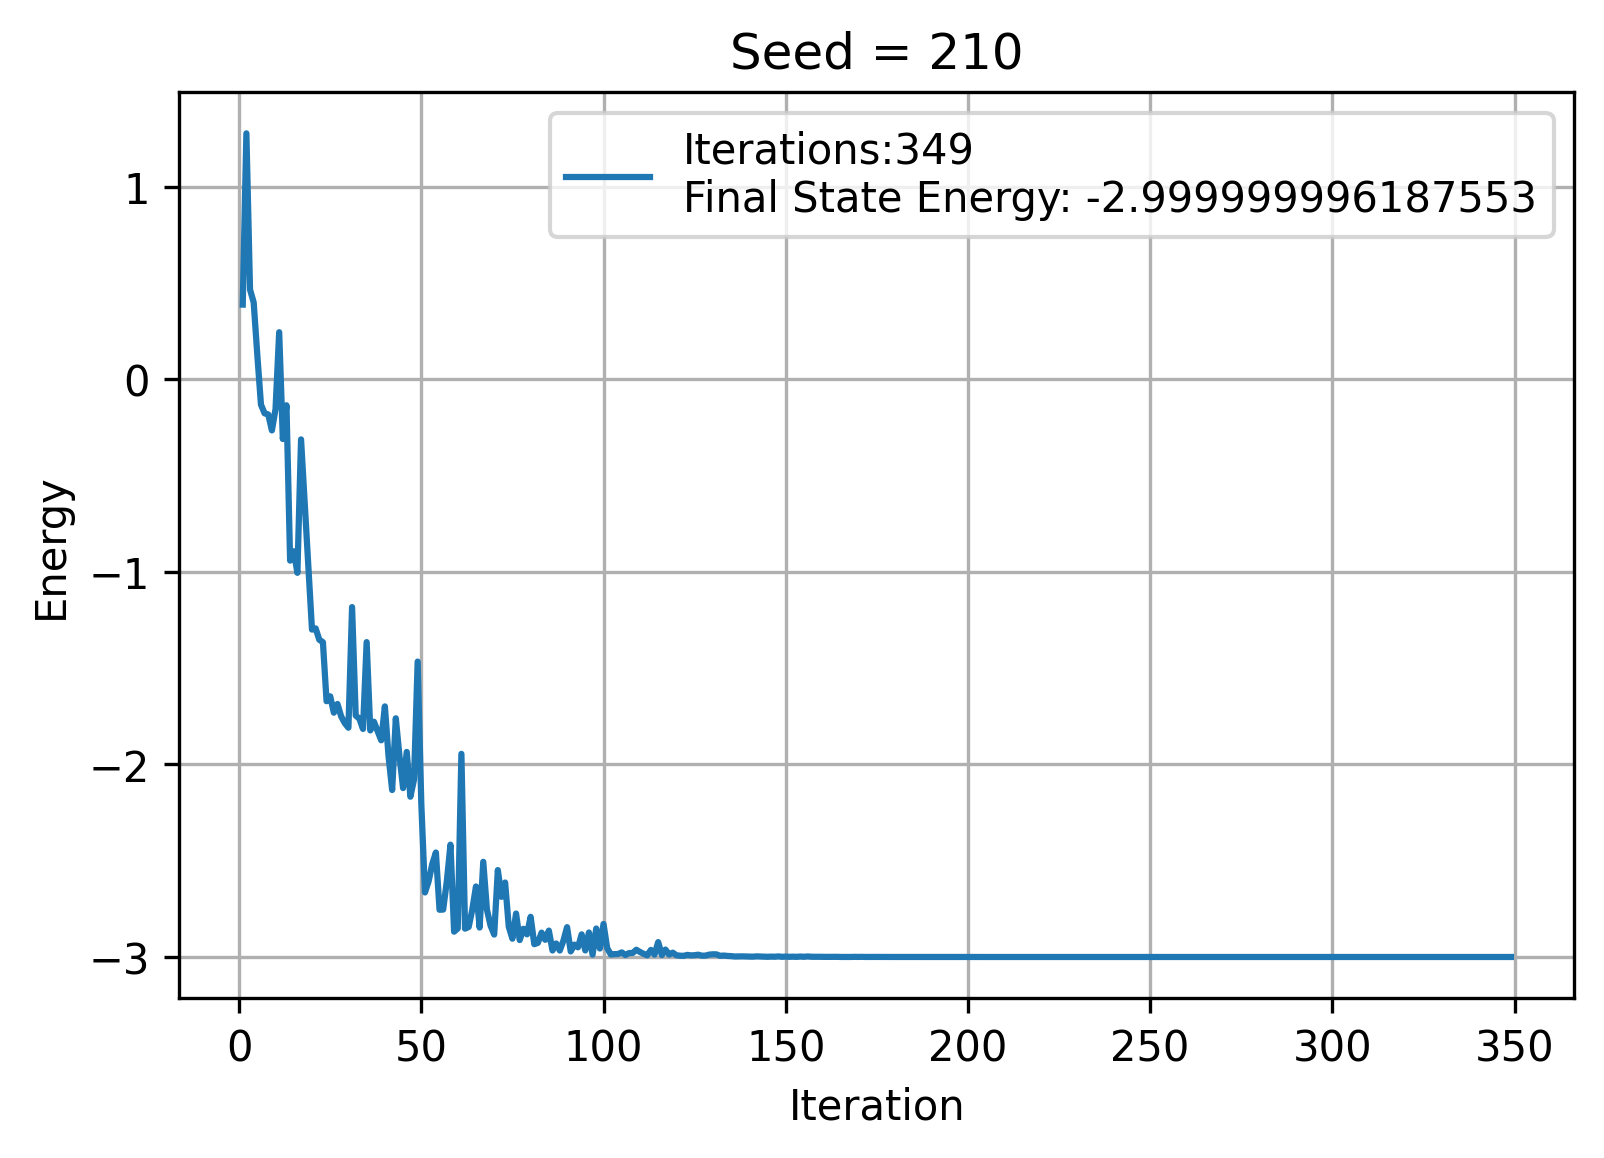

In [24]:
seed = 210
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(3)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
# construct VQE
cobyla = COBYLA(maxiter=2000)
ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
counts, values = [], []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
vqe = VQE(ry, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=quantum_instance)
    
# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
plt.figure(dpi = 300)
plt.plot(converge_cnts, converge_vals, label =  "Iterations:" + str(int(len(converge_cnts))) + "\n" + "Final State Energy: " + str(converge_vals[-1]))
plt.title('Seed = ' + str(seed))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.grid()
plt.show()

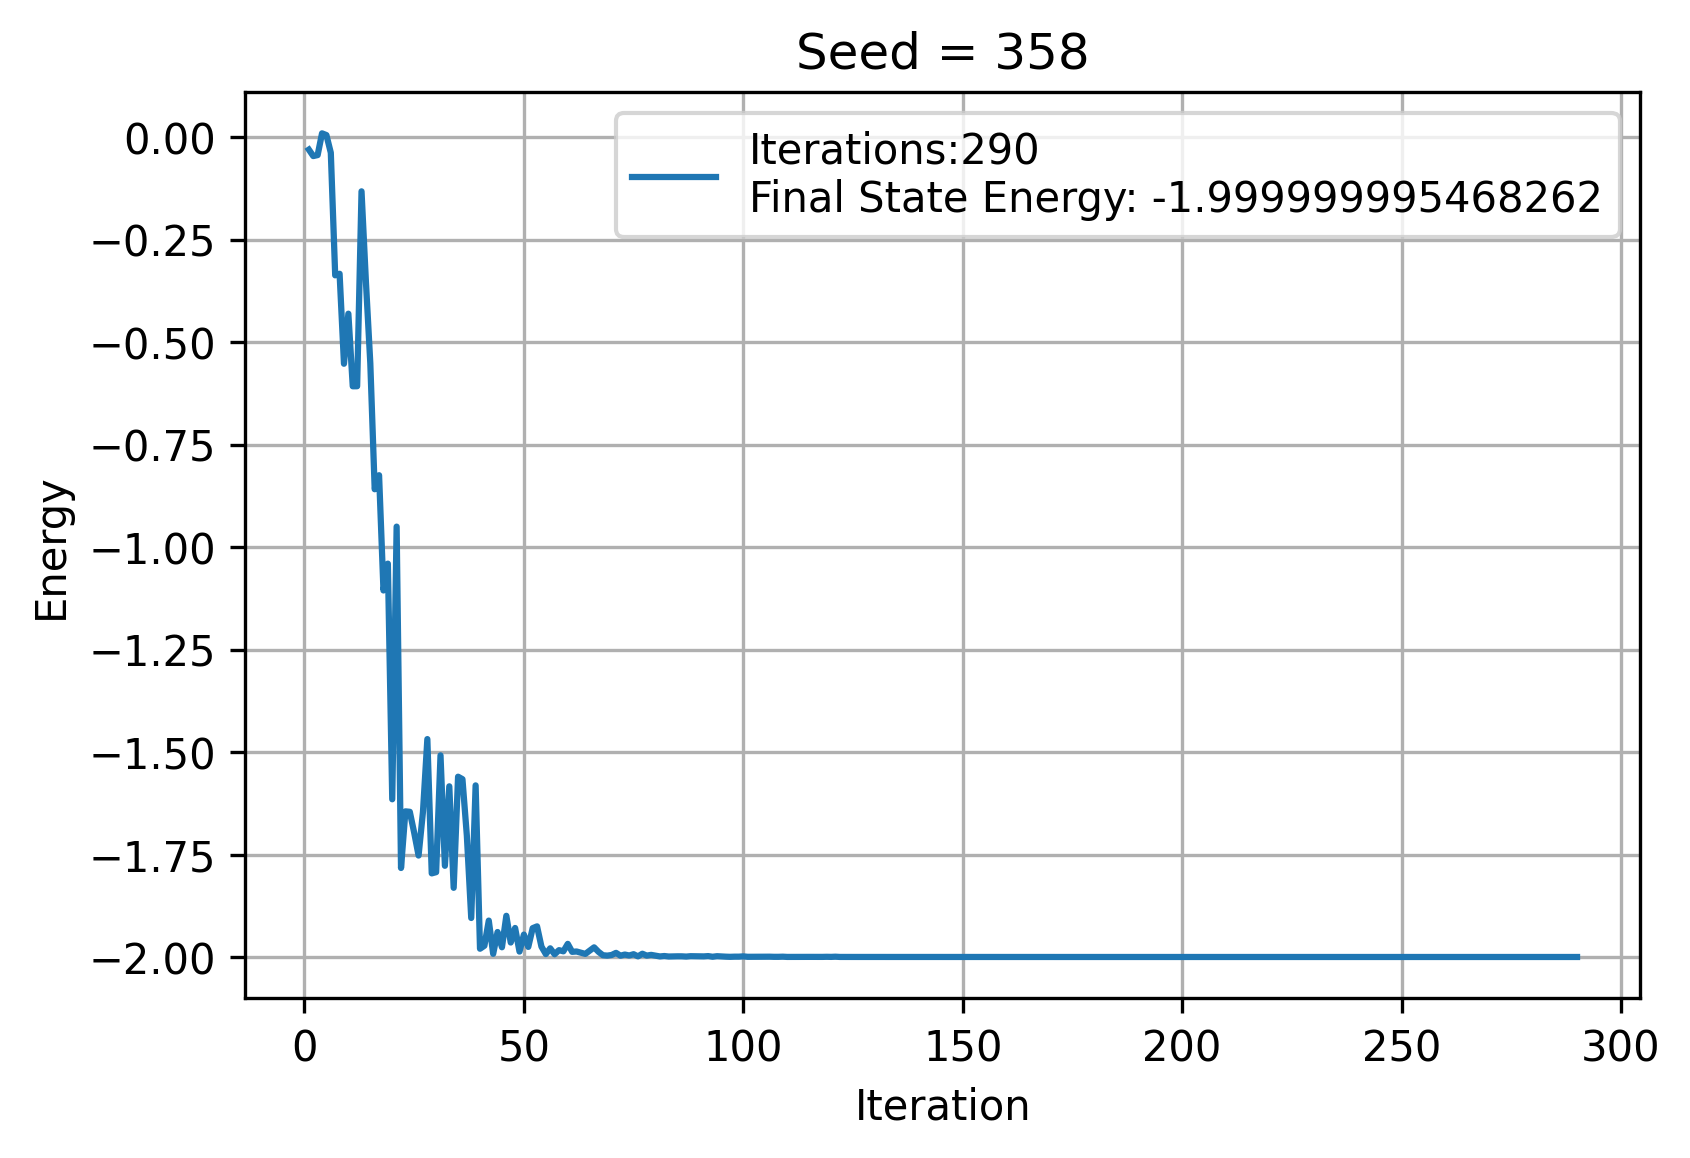

In [25]:
seed = 358
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(3)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
# construct VQE
cobyla = COBYLA(maxiter=2000)
ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
counts, values = [], []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
vqe = VQE(ry, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=quantum_instance)
    
# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
plt.figure(dpi = 300)
plt.plot(converge_cnts, converge_vals, label =  "Iterations:" + str(int(len(converge_cnts))) + "\n" + "Final State Energy: " + str(converge_vals[-1]))
plt.title('Seed = ' + str(seed))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.grid()
plt.show()

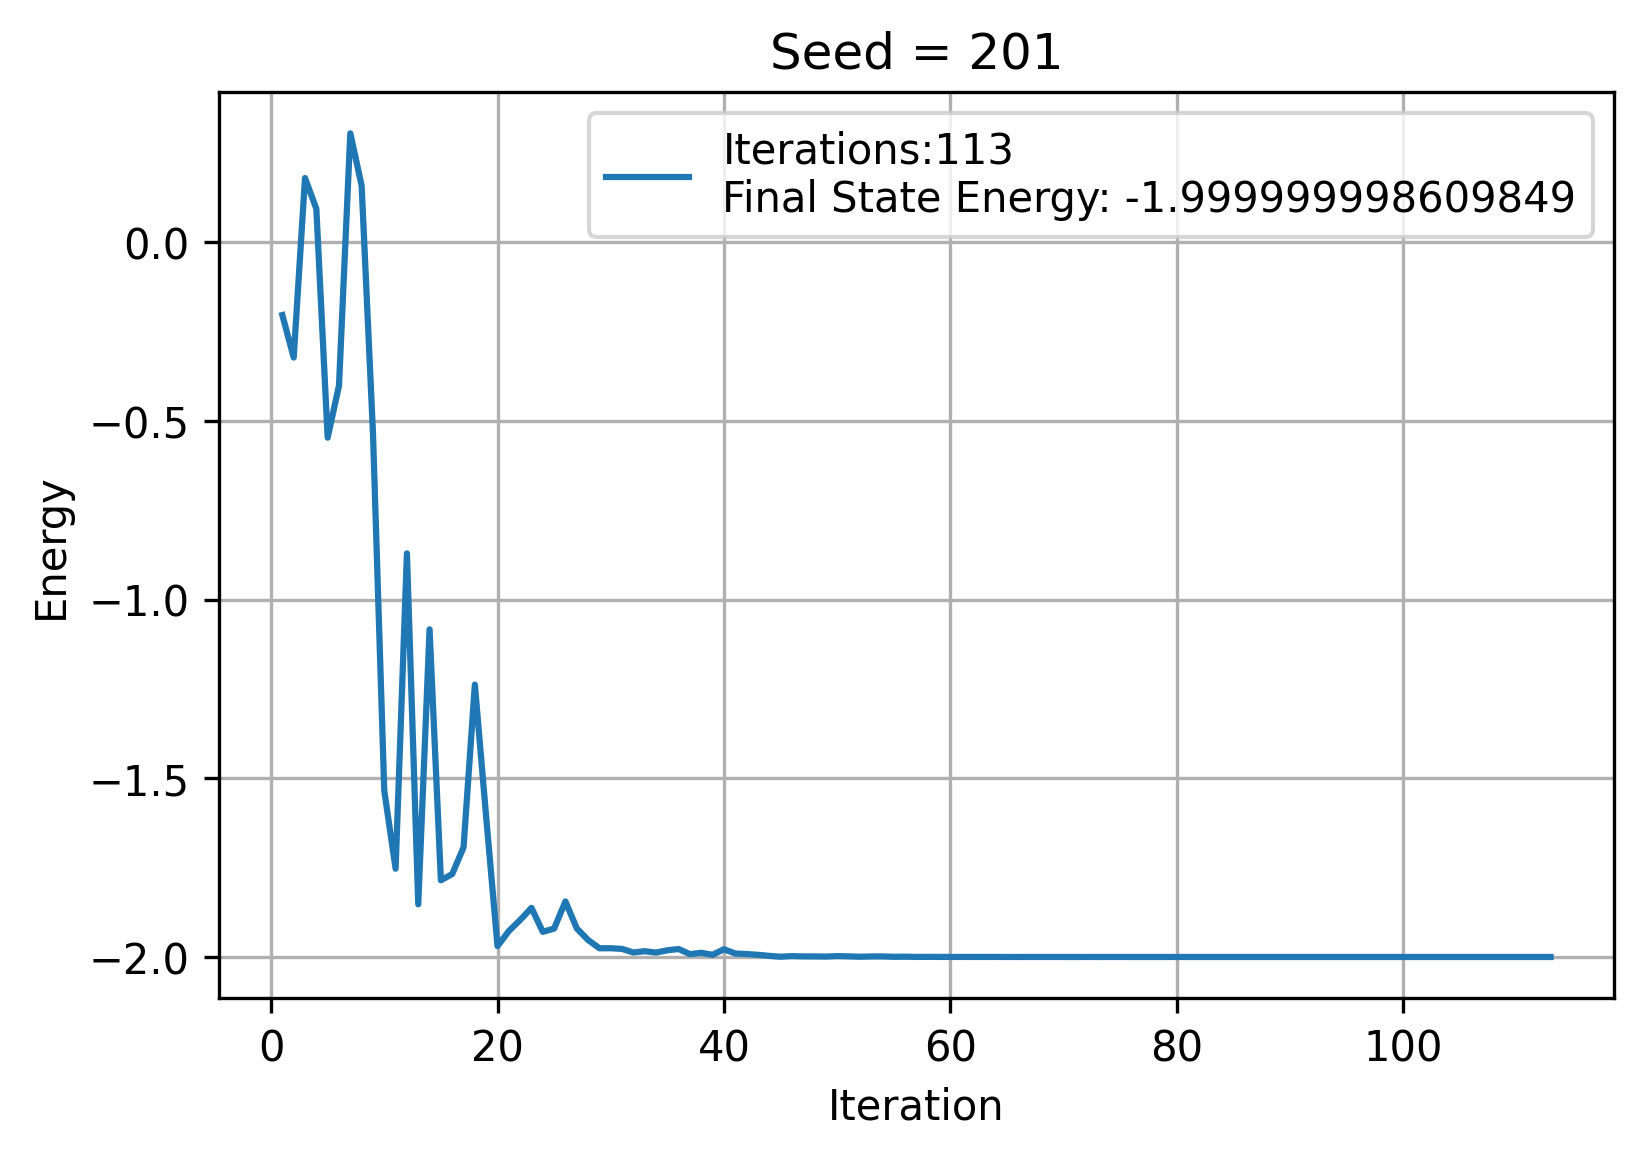

In [33]:
seed = 201
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(2)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
# construct VQE
cobyla = COBYLA(maxiter=200)
ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
counts, values = [], []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
vqe = VQE(ry, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=quantum_instance)
    
# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
plt.figure(dpi = 300)
plt.plot(converge_cnts, converge_vals, label =  "Iterations:" + str(int(len(converge_cnts))) + "\n" + "Final State Energy: " + str(converge_vals[-1]))
plt.title('Seed = ' + str(seed))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.grid()
plt.show()

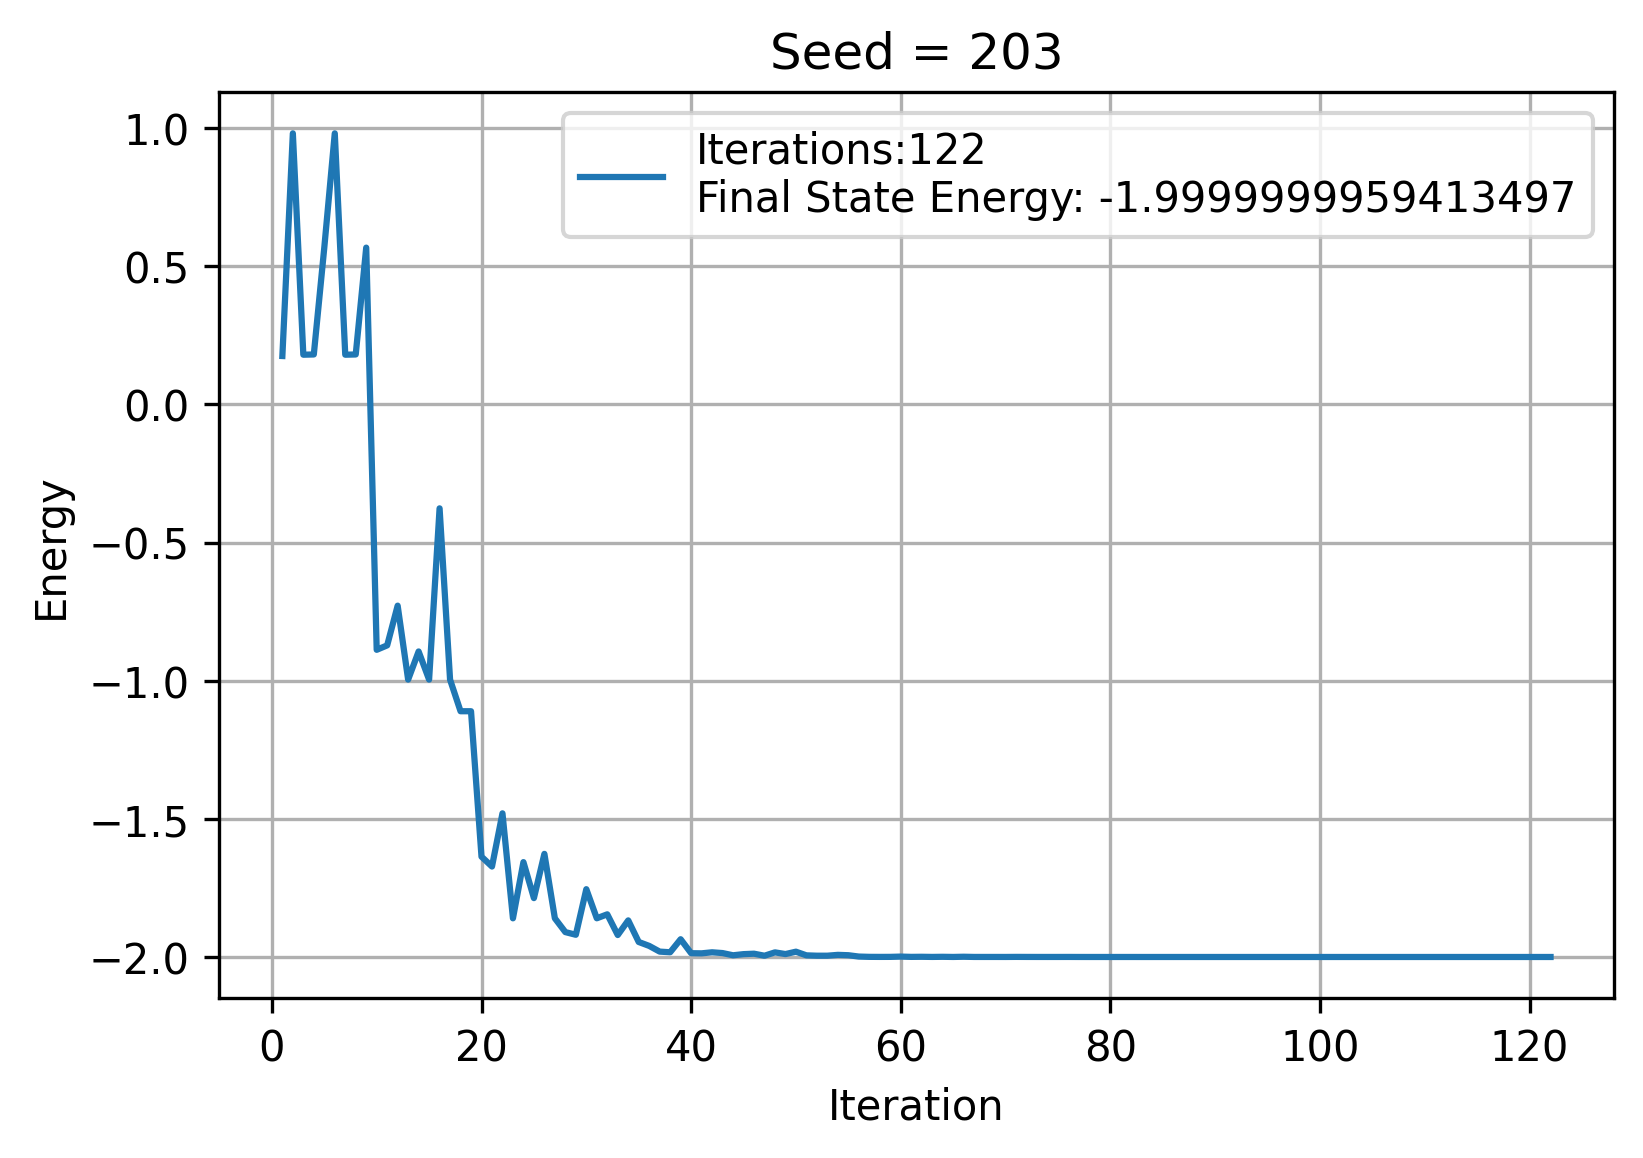

In [34]:
seed = 203
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(2)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
# construct VQE
cobyla = COBYLA(maxiter=200)
ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
counts, values = [], []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
vqe = VQE(ry, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=quantum_instance)
    
# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
plt.figure(dpi = 300)
plt.plot(converge_cnts, converge_vals, label =  "Iterations:" + str(int(len(converge_cnts))) + "\n" + "Final State Energy: " + str(converge_vals[-1]))
plt.title('Seed = ' + str(seed))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.grid()
plt.show()

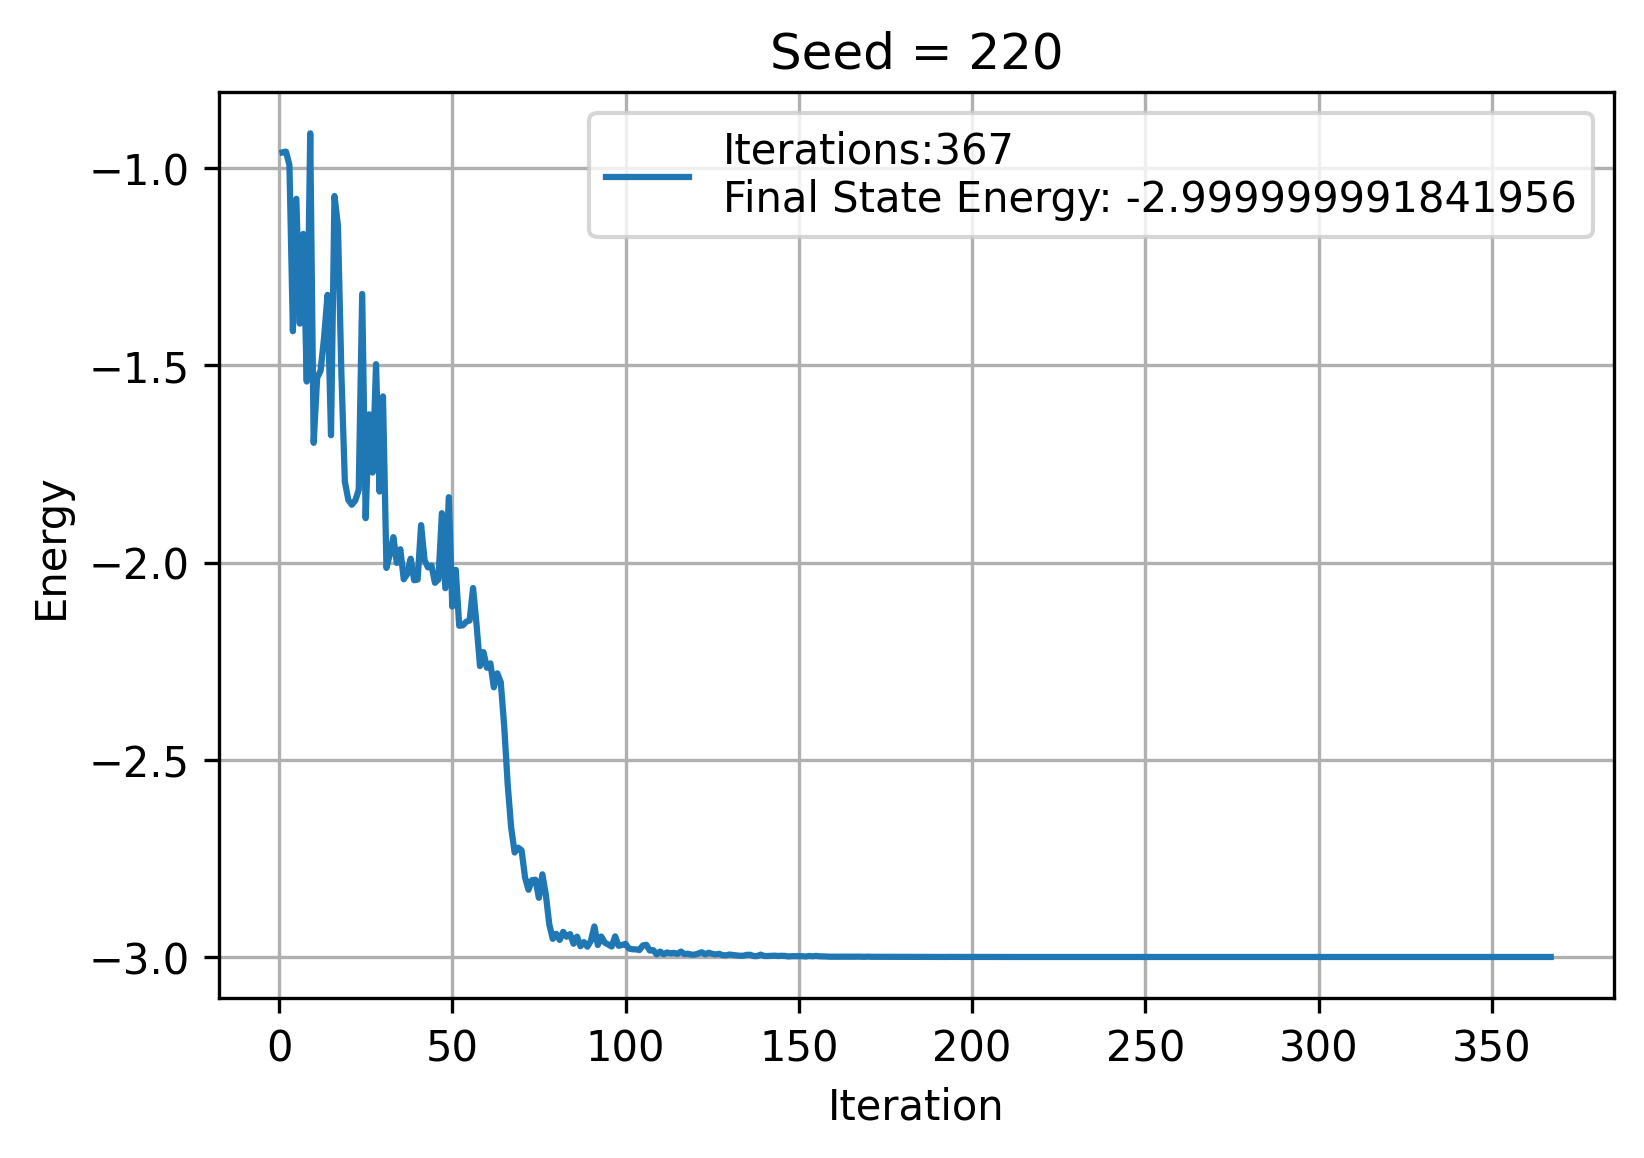

In [35]:
seed = 220
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(3)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
# construct VQE
cobyla = COBYLA(maxiter=2000)
ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
counts, values = [], []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
vqe = VQE(ry, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=quantum_instance)
    
# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
plt.figure(dpi = 300)
plt.plot(converge_cnts, converge_vals, label =  "Iterations:" + str(int(len(converge_cnts))) + "\n" + "Final State Energy: " + str(converge_vals[-1]))
plt.title('Seed = ' + str(seed))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.grid()
plt.show()

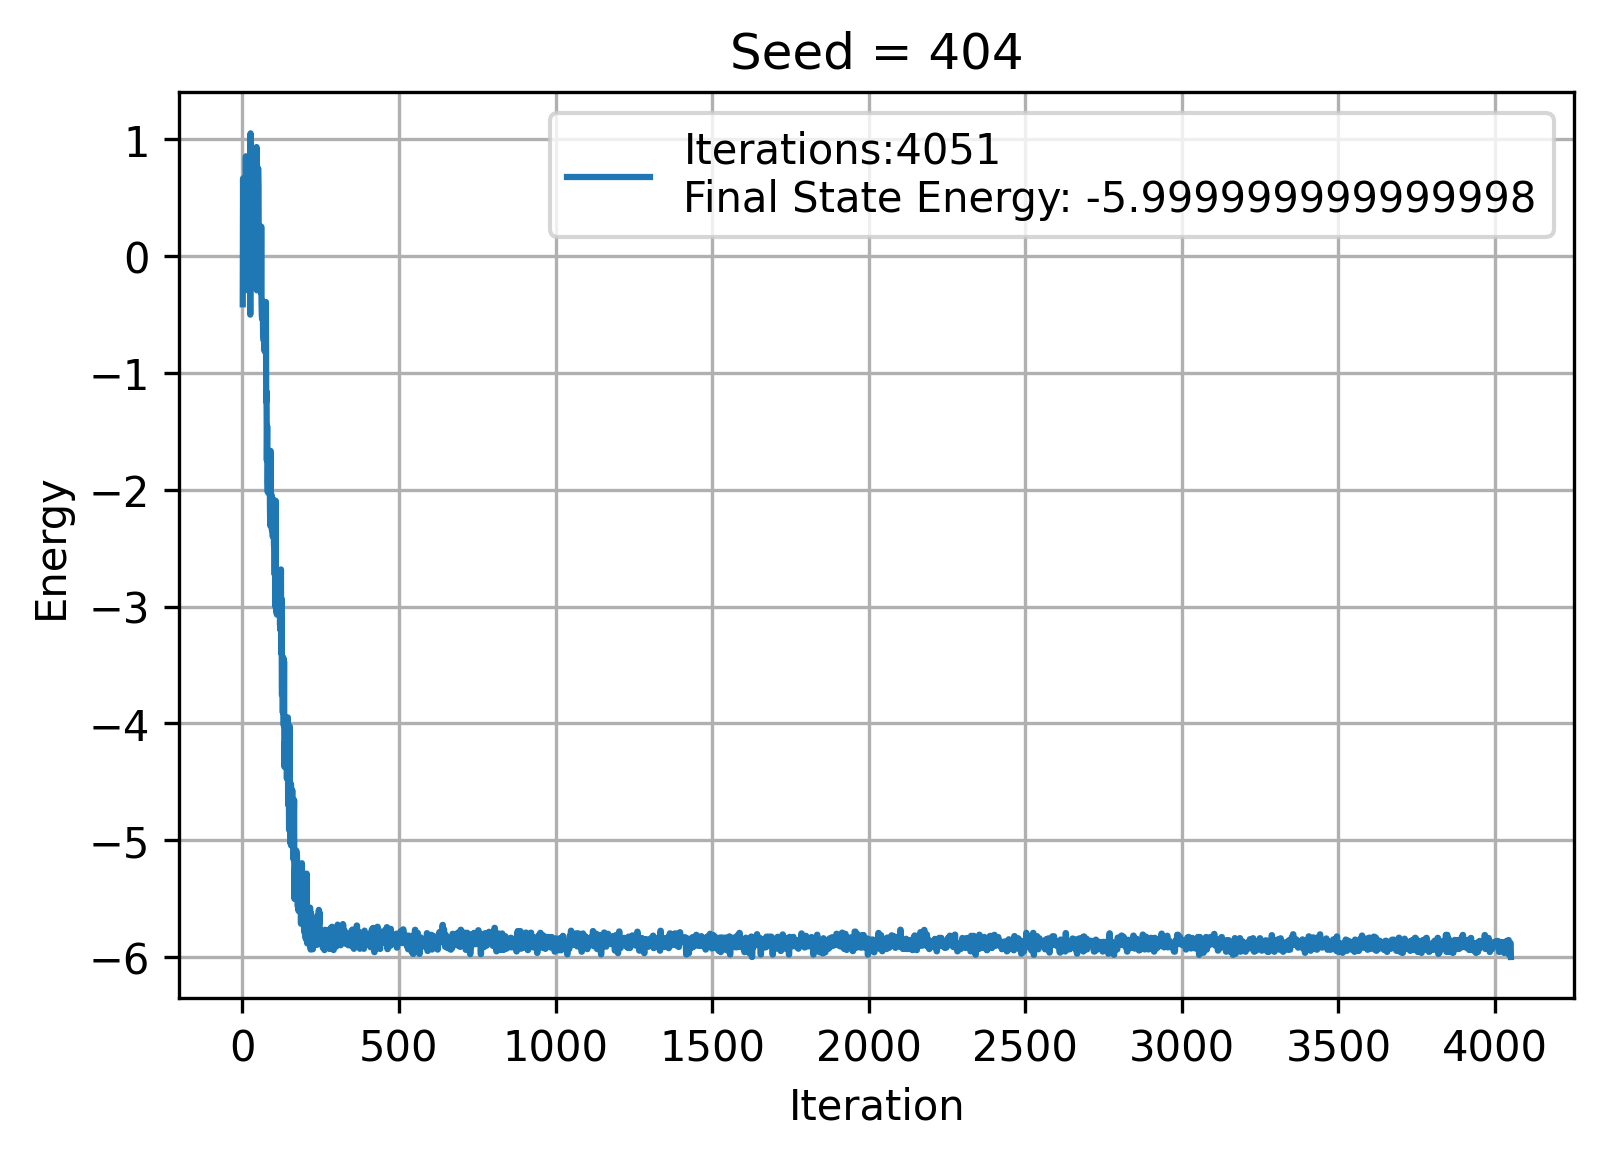

In [43]:
seed = 404
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(3)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
    
# construct VQE
spsa = SPSA(maxiter=2000)
ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
counts, values = [], []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
vqe = VQE(ry, optimizer=spsa, callback=store_intermediate_result, quantum_instance=quantum_instance)
    
# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
plt.figure(dpi = 300)
plt.plot(converge_cnts, converge_vals, label =  "Iterations:" + str(int(len(converge_cnts))) + "\n" + "Final State Energy: " + str(converge_vals[-1]))
plt.title('Seed = ' + str(seed))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.grid()
plt.show()

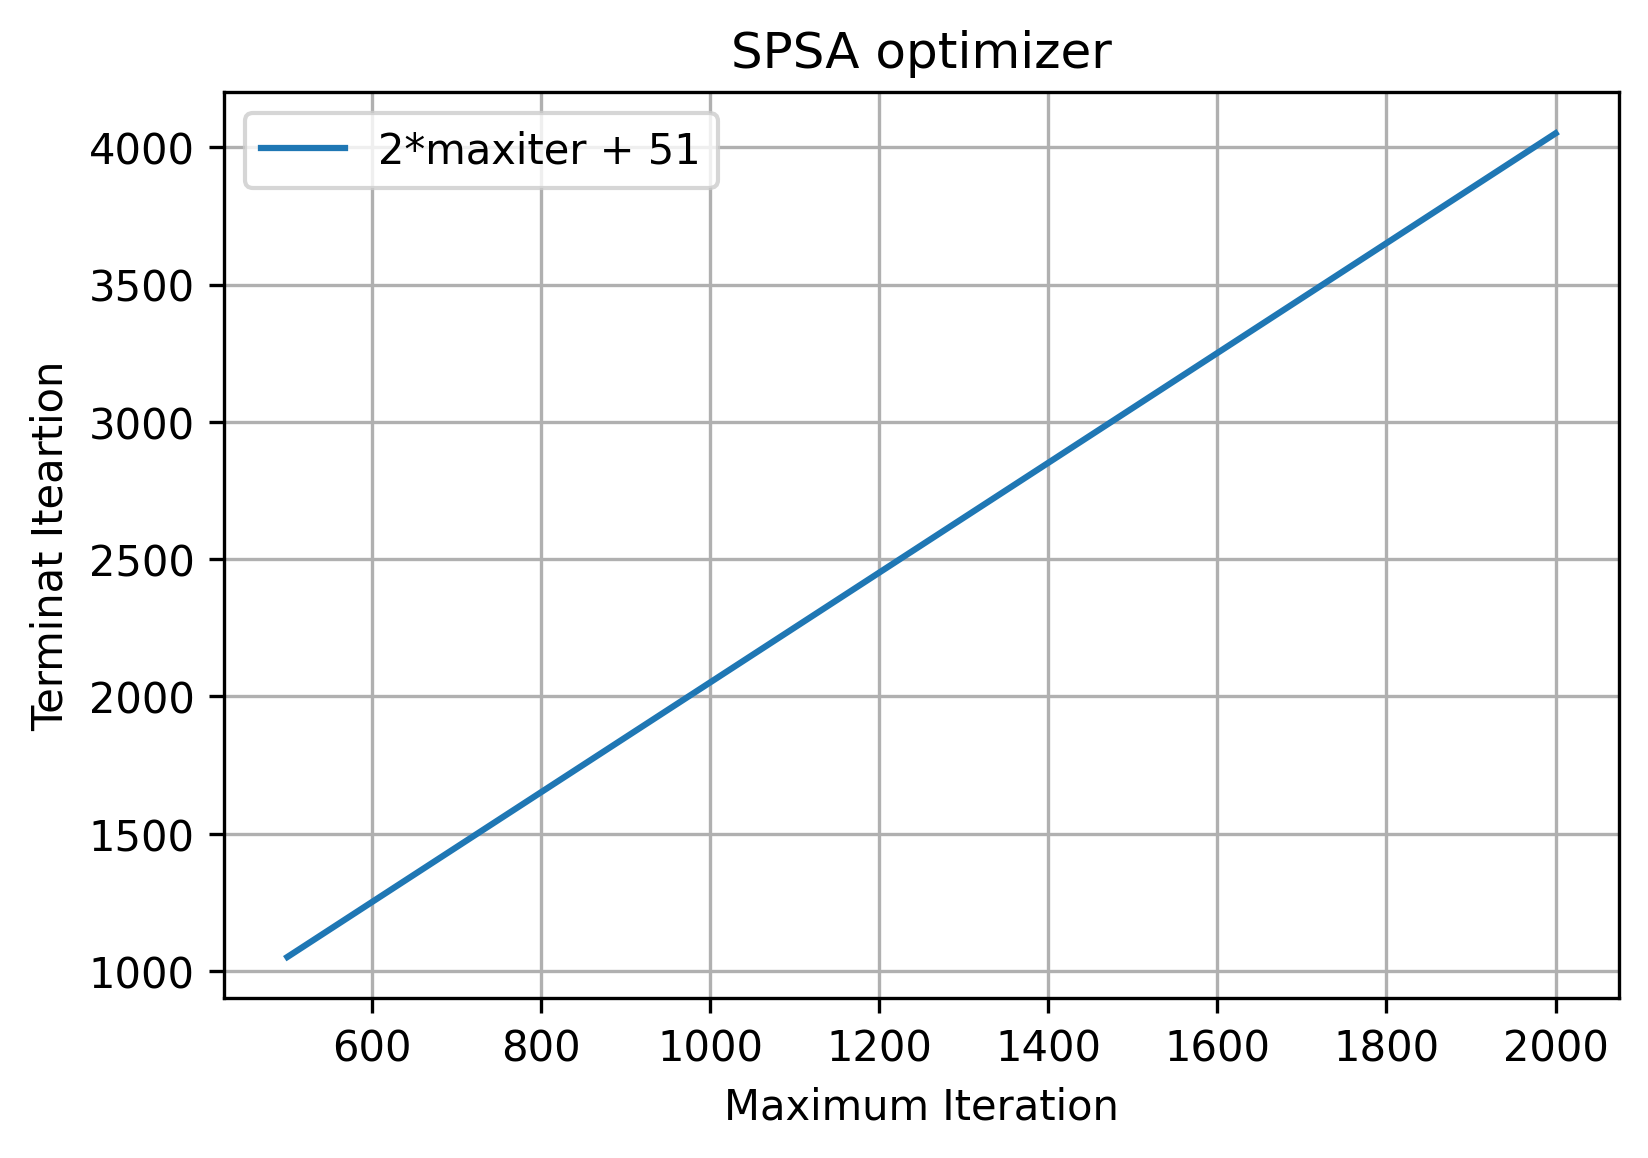

In [53]:
seed = 201
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

G, w, pos = graph_generation(3)
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())

maxiters = []
terminate_iter = []
for i in np.arange(500, 2001, 100):
    # construct VQE
    spsa = SPSA(maxiter=i)
    ry = TwoLocal(qubitOp.num_qubits, "ry", reps=1, entanglement="linear")
    counts, values, Parameters= [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        Parameters.append(parameters)
    vqe = VQE(ry, optimizer=spsa, callback=store_intermediate_result, quantum_instance=quantum_instance)

    # run VQE
    result = vqe.compute_minimum_eigenvalue(qubitOp)
    converge_cnts = np.asarray(counts)
    converge_vals = np.asarray(values)
    maxiters.append(i)
    terminate_iter.append(converge_cnts[-1])
plt.figure(dpi = 300)
plt.plot(maxiters, terminate_iter, label = r'2*maxiter + 51')
plt.title('SPSA optimizer')
plt.legend()
plt.xlabel('Maximum Iteration')
plt.ylabel('Terminat Iteartion')
plt.grid()
plt.show()

In [49]:
Parameters

[array([ 6.36674211,  0.66034797, -0.34650693,  1.35578431,  2.5131349 ,
         0.04761005, -4.18078914,  0.33778399,  4.68710288,  5.55093804,
        -0.12058336,  0.9405004 , -4.53735057, -6.05053762,  3.7609804 ,
        -3.28939104, -4.94922461, -3.41715431]),
 'trial',
 array([ 5.96674211,  0.26034797,  0.05349307,  0.95578431,  2.1131349 ,
         0.44761005, -4.58078914,  0.73778399,  5.08710288,  5.95093804,
         0.27941664,  0.5405004 , -4.13735057, -6.45053762,  3.3609804 ,
        -2.88939104, -5.34922461, -3.81715431]),
 'trial',
 array([ 5.96674211,  0.66034797, -0.34650693,  1.35578431,  2.5131349 ,
         0.04761005, -4.18078914,  0.33778399,  4.68710288,  5.95093804,
         0.27941664,  0.9405004 , -4.53735057, -6.05053762,  3.3609804 ,
        -2.88939104, -4.94922461, -3.41715431]),
 'trial',
 array([ 6.36674211,  0.26034797,  0.05349307,  0.95578431,  2.1131349 ,
         0.44761005, -4.58078914,  0.73778399,  5.08710288,  5.55093804,
        -0.12058336,

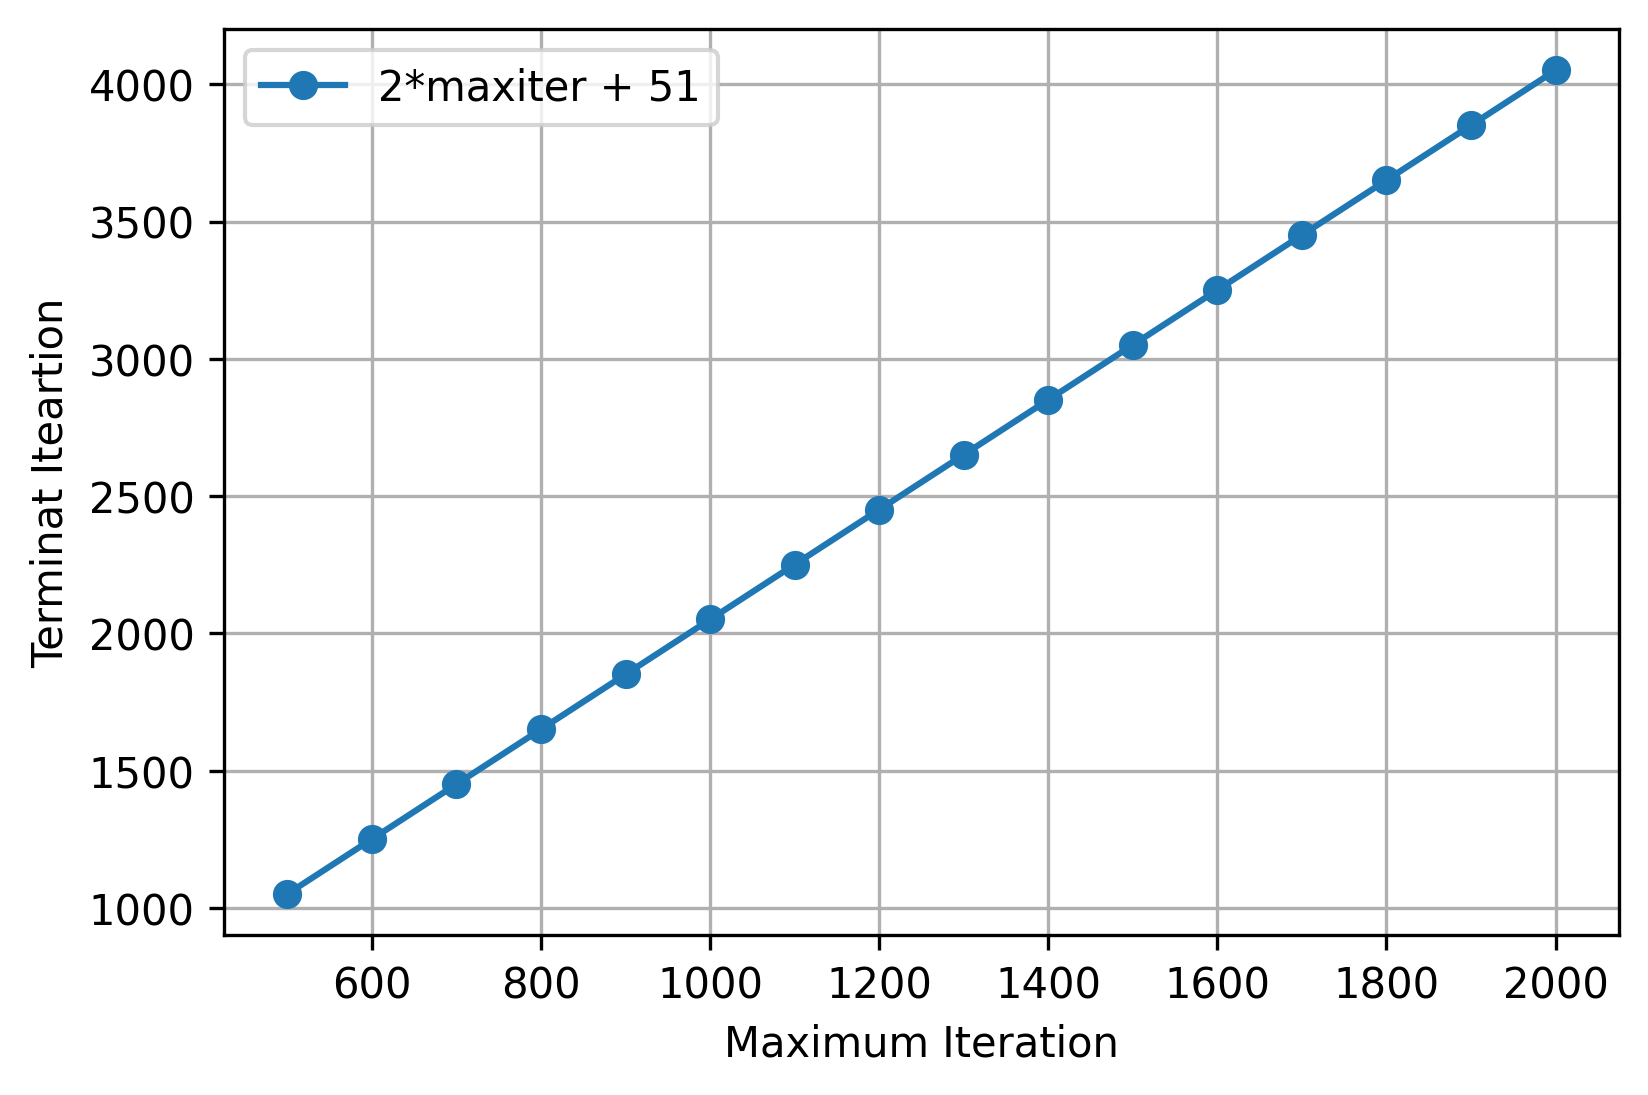

In [56]:
plt.figure(dpi = 300)
plt.plot(maxiters, terminate_iter, marker = 'o', label = r'2*maxiter + 51')
plt.legend()
plt.xlabel('Maximum Iteration')
plt.ylabel('Terminat Iteartion')
plt.grid()
plt.show()